In [2]:
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Activation, Dropout, BatchNormalization, Layer
from keras.models import Model
from keras.optimizers import Adam
from keras.datasets import reuters
from keras.callbacks import EarlyStopping
import numpy as np

In [3]:
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [42]:
# V = 10922
# (x_train, _), (_, _) = reuters.load_data(start_char=None, oov_char=None, index_from=-1, num_words=V) # remove words having freq(q) <= 5
# word_index = reuters.get_word_index()
# index2word = {v-1: k for k, v in word_index.items()} # zero-origin word index
# x_train = np.array([np.bincount(doc, minlength=V) for doc in x_train])
# x_train = x_train[:8000, :]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [31]:
import pickle
vocab = 'data/vocab.pkl'
vocab = pickle.load(open(vocab,'rb'))
vocab_size=len(vocab)
V = vocab_size
word_index = dict(vocab)
index2word = {v-1: k for k, v in word_index.items()} # zero-origin word index

train = 'data/train.txt.npy'
x_train1 = np.load(train, allow_pickle=True, encoding='bytes')
test = 'data/test.txt.npy'
x_test1 = np.load(test, allow_pickle=True, encoding='bytes')




In [20]:
V

1995

In [32]:

x_train = np.array([np.bincount(doc.astype('int'), minlength=V) for doc in x_train1])
x_test = np.array([np.bincount(doc.astype('int'), minlength=V) for doc in x_test1])


In [68]:
# x_train = np.array([onehot(doc.astype('int'),vocab_size) for doc in x_train1 if np.sum(doc)!=0])
# x_test = np.array([onehot(doc.astype('int'),vocab_size) for doc in x_test1 if np.sum(doc)!=0])


In [40]:
x_train = x_train[:10000]

In [33]:

num_hidden = 100
num_topic = 50
batch_size = 200
alpha = 1./20

In [34]:
mu1 = np.log(alpha) - 1/num_topic*num_topic*np.log(alpha)
sigma1 = 1./alpha*(1-2./num_topic) + 1/(num_topic**2)*num_topic/alpha
inv_sigma1 = 1./sigma1
log_det_sigma = num_topic*np.log(sigma1)

In [35]:
x = Input(batch_shape=(batch_size, V))
h = Dense(num_hidden, activation='softplus')(x)
h = Dense(num_hidden, activation='softplus')(h)
z_mean = BatchNormalization()(Dense(num_topic)(h))
z_log_var = BatchNormalization()(Dense(num_topic)(h))

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, num_topic),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

unnormalized_z = Lambda(sampling, output_shape=(num_topic,))([z_mean, z_log_var])

theta = Activation('softmax')(unnormalized_z)
theta = Dropout(0.5)(theta)
doc = Dense(units=V)(theta)
doc = BatchNormalization()(doc)
doc = Activation('softmax')(doc)

In [36]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, inference_x):
        decoder_loss = K.sum(x * K.log(inference_x), axis=-1)
        encoder_loss = -0.5*(K.sum(inv_sigma1*K.exp(z_log_var) + K.square(z_mean)*inv_sigma1 - 1 - z_log_var, axis=-1) + log_det_sigma)
        return -K.mean(encoder_loss + decoder_loss)

    def call(self, inputs):
        x = inputs[0] 
        inference_x = inputs[1]
        loss = self.vae_loss(x, inference_x)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [41]:
y = CustomVariationalLayer()([x, doc])
prodLDA = Model(x, y)
prodLDA.compile(optimizer=Adam(lr=0.001, beta_1=0.99), loss=None)

In [42]:
prodLDA.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(200, 1995)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (200, 100)           199600      input_4[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (200, 100)           10100       dense_15[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (200, 50)            5050        dense_16[0][0]                   
____________________________________________________________________________________________

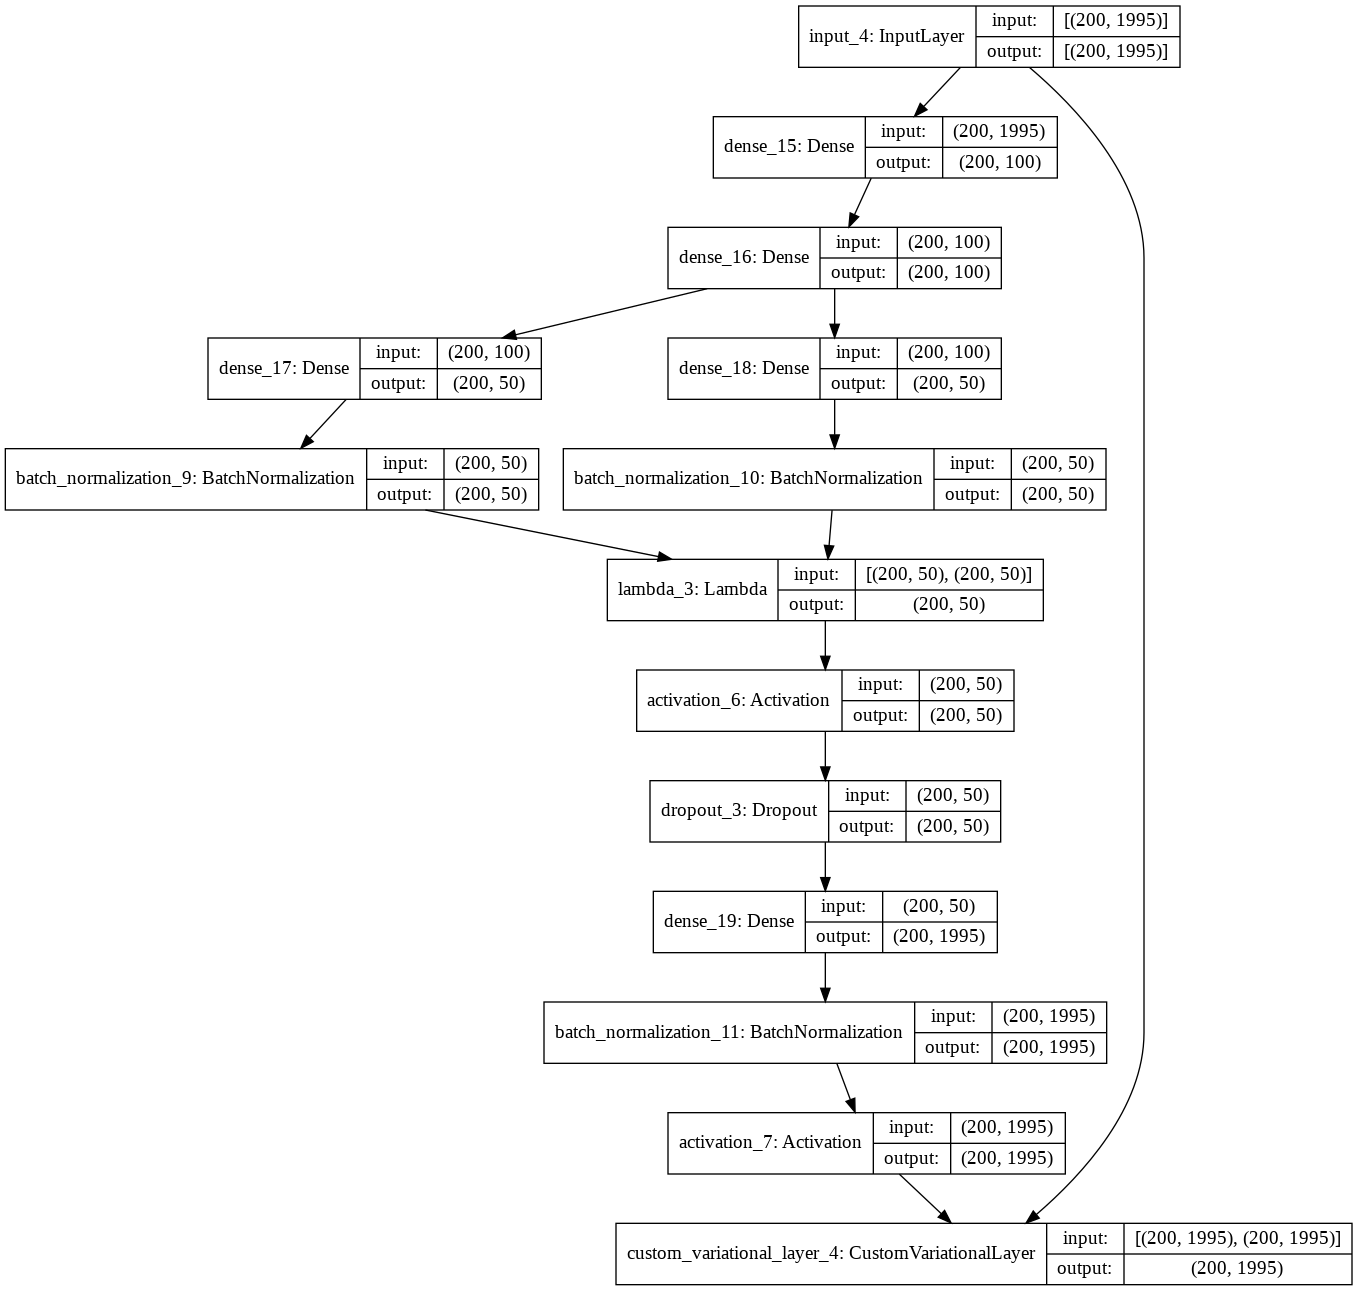

In [47]:
tf.keras.utils.plot_model(prodLDA, show_shapes=True)

In [48]:
prodLDA.fit(x_train, verbose=1, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(patience=10)], epochs=100)


Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 1s 144us/sample - loss: 572.0092 - val_loss: 947.7387
Epoch 2/100
9000/9000 [==============================] - 1s 134us/sample - loss: 570.0554 - val_loss: 946.2406
Epoch 3/100
9000/9000 [==============================] - 1s 136us/sample - loss: 569.0452 - val_loss: 945.0543
Epoch 4/100
9000/9000 [==============================] - 1s 141us/sample - loss: 567.6040 - val_loss: 944.0573
Epoch 5/100
9000/9000 [==============================] - 1s 139us/sample - loss: 565.7933 - val_loss: 943.9408
Epoch 6/100
9000/9000 [==============================] - 1s 133us/sample - loss: 565.1476 - val_loss: 941.6237
Epoch 7/100
9000/9000 [==============================] - 1s 135us/sample - loss: 564.7496 - val_loss: 941.4677
Epoch 8/100
9000/9000 [==============================] - 1s 137us/sample - loss: 563.4313 - val_loss: 940.7920
Epoch 9/100
9000/9000 [==============================] - 1s 137u

In [49]:

exp_beta = np.exp(prodLDA.get_weights()[-6]).T
phi = (exp_beta/np.sum(exp_beta, axis=0)).T

In [50]:

for k, phi_k in enumerate(phi):
    print('topic: {}'.format(k))
    for w in np.argsort(phi_k)[::-1][:10]:
        print(index2word[w], phi_k[w])
    print()

topic: 0
stone 0.0005539902
network 0.00055209524
drug 0.00055168883
last 0.0005506575
quick 0.0005497024
return 0.0005488783
really 0.0005482817
participate 0.000547706
quote 0.00054755004
come 0.0005441038

topic: 1
first 0.00056685717
database 0.00055954803
nasa 0.0005588756
frequency 0.0005577037
greatly 0.00055767916
different 0.00055700284
lewis 0.0005569575
want 0.00055687403
budget 0.00055665855
thinking 0.00055642595

topic: 2
good 0.000629075
definition 0.0006273461
revelation 0.00062328647
solid 0.0006209678
two 0.000620111
connector 0.0006197012
sick 0.0006192059
reply 0.00061829033
loss 0.000618264
background 0.0006178923

topic: 3
seattle 0.0005765417
strongly 0.00057613885
cipher 0.00057473587
postscript 0.0005707243
blue 0.00056731154
certainly 0.0005668145
primary 0.0005648128
attempt 0.0005647228
limited 0.0005621263
challenge 0.00056139677

topic: 4
initial 0.0006118099
control 0.0005971715
element 0.00059361634
bh 0.000593171
adams 0.0005926091
merely 0.0005906029
b

KeyError: ignored